In [33]:

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss
import pandas as pd
import datetime as dt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from urllib.request import urlretrieve


from sklearn.model_selection import train_test_split

In [34]:
url_train = 'https://raw.githubusercontent.com/joaquinhojman/ArbolesDeDecision/main/data_train.csv'
url_test = 'https://raw.githubusercontent.com/joaquinhojman/ArbolesDeDecision/main/data_test.csv'
url_test_kaggle = 'https://raw.githubusercontent.com/joaquinhojman/ArbolesDeDecision/main/data_test_kaggle.csv'

data_train = pd.read_csv(url_train)
data_test = pd.read_csv(url_test)
data_test_kaggle = pd.read_csv(url_test_kaggle)


In [35]:
# Separamos los set de datos (data_train y data_test) de sus columnas 'Target'
# 'x' son los datos, 'y' es el target:
#   --> x_train son los datos con los que entrenar
#   --> y_train son las soluciones con las que comparar lo entrenado con x_train
#   --> x_test son los datos con los que probar
#   --> y_test son las soluciones con las que comparar lo probado con x_test
x_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
x_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

#Esto lo hizo chechu y esta bien, no cambiar.


In [36]:
import lightgbm as lgb

In [37]:
!pip install hyperopt
from hyperopt.pyll.base import scope 
import warnings
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [38]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)
space={'max_depth': hp.quniform("max_depth", 7, 16, 1),
      #  'learning_rate' : hp.quniform('learning_rate', 0.001, 0.5, 0.01),
        'min_samples_split' :hp.quniform('min_samples_split',2,300,25),
        'num_leaves': hp.quniform('num_leaves', 10,80,1),
      #  'feature_fraction': hp.quniform('feature_fraction', 0.01,1,1),
        'min_data': hp.quniform('min_data', 10,100,1),
    }



def hyperparameter_tuning(space):

    model = lgb.LGBMRegressor(max_depth=int(space['max_depth']),min_samples_split=int(space['min_samples_split']),num_leaves=int(space['num_leaves']),
        min_data=int(space['min_data']),learning_rate=0.05,
        feature_fraction=0.22,
            )
    #  model=lgb.train(params,lgb_train)        
    model.fit(x_train, y_train)                    
    preds = model.predict(x_test)

    logloss = log_loss(y_test, preds)
    print(logloss)
    #change the metric if you like
    return {'loss':logloss, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=500,
            trials=trials)


print (best)

0.41968562862934833
0.4439635530874617
0.4289125738684797
0.4399618203262851
0.4463990500895129
0.4419700633907953
0.4436185896546168
0.43334257938743365
0.4401688398399935
0.4165832780452125
0.4261278419849935
0.4197731172321783
0.4327754917396054
0.47069458118158275
0.44801283252187113
0.4268145766552965
0.43254314063078
0.42378095569104873
0.443918249634708
0.42645085939208305
0.4153578873217142
0.4185127200066575
0.4294578207282173
0.4065671984544361
0.4240661076640213
0.4341432092318765
0.4189352270724691
0.42292998879482907
0.4206752795991505
0.41541245259093995
0.4501184276810562
0.4288568727652356
0.4210826878571553
0.44604161008198606
0.4333767444573009
0.4126650531999518
0.42455122858874444
0.41012034338653736
0.4238749965616393
0.4311555238812684
0.4628031033207845
0.43561501257391866
0.4188009146606072
0.4304652766633012
0.4297004425657017
0.42450906375713254
0.4382197314785075
0.41953307678346186
0.41827136661889996
0.42722633722913034
0.45182527200451256
0.445027656778296

In [39]:

#best loss: 0.3978530719311108] #en kaggle = 0.47
#{'max_depth': 15.0, 'min_data': 27.0, 'min_samples_split': 125.0, 'num_leaves': 49.0}

best

{'max_depth': 10.0,
 'min_data': 12.0,
 'min_samples_split': 200.0,
 'num_leaves': 46.0}

In [40]:
lgb_hyper = lgb.LGBMRegressor(max_depth=15,min_samples_split=125,num_leaves=49,
        min_data=27,learning_rate=0.05,feature_fraction=0.22)
lgb_hyper.fit(x_train, y_train)                    
preds = lgb_hyper.predict(x_test)

logloss = log_loss(y_test, preds)
logloss


0.3978530719311108

In [41]:
#Error de train
preds_train_hyper = lgb_hyper.predict(x_train)
error_train_hyper = log_loss(y_train, preds_train_hyper)
error_train_hyper

0.16751311397099558

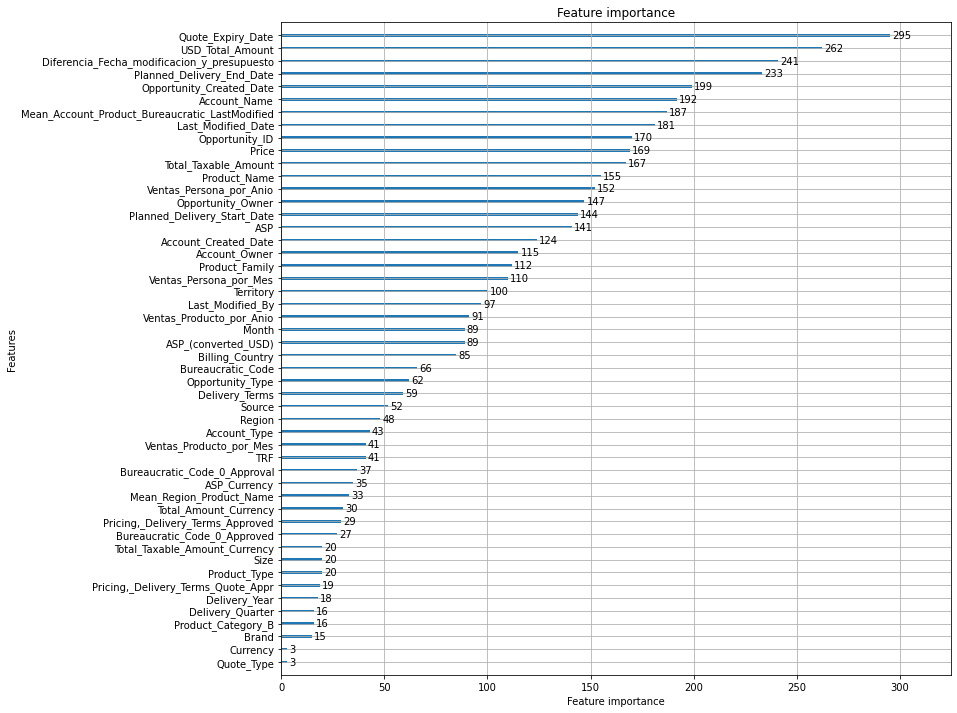

In [42]:
plt.rcParams['figure.figsize'] = [12, 12]

lgb.plot_importance(lgb_hyper)

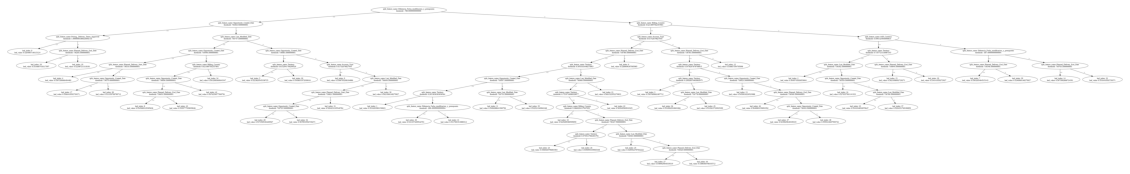

In [43]:
plt.rcParams['figure.figsize'] = [20, 20]
lgb.plot_tree(lgb_hyper)

In [44]:
# Sacamos el y_test_de_practica_agrupado_por_opp
oportunidades_test_de_practica = x_test['Opportunity_ID']
oportunidades_test_de_practica = oportunidades_test_de_practica.to_frame()

stage_test_de_practica = y_test.to_frame()

oportunidades_test_de_practica['Target'] = stage_test_de_practica
y_test_agrupado_por_opp = oportunidades_test_de_practica.groupby('Opportunity_ID').agg({'Target' : 'mean'})
y_test_agrupado_por_opp = y_test_agrupado_por_opp.reset_index()

In [45]:
# Sacamos el preds_agrupado_por_opp
oportunidades_test_de_practica = x_test['Opportunity_ID']
oportunidades_test_de_practica = oportunidades_test_de_practica.to_frame()

oportunidades_test_de_practica['Target'] = preds

preds_agrupado_por_opp = oportunidades_test_de_practica.groupby('Opportunity_ID').agg({'Target' : 'mean'})
preds_agrupado_por_opp = preds_agrupado_por_opp.reset_index()

In [46]:
# Calculamos el error con groupby hecho
error = log_loss(y_test_agrupado_por_opp['Target'], np.nan_to_num(preds_agrupado_por_opp['Target'].to_numpy()))
error

0.4091789963346319

In [47]:
# Sacamos el preds_test_agrupado_por_opp
preds_test_kaggle_hyper = lgb_hyper.predict(data_test_kaggle)

oportunidades_test = data_test_kaggle['Opportunity_ID']
oportunidades_test = oportunidades_test.to_frame()

oportunidades_test['Target'] = preds_test_kaggle_hyper

preds_test_kaggle_agrupado_por_opp = oportunidades_test.groupby('Opportunity_ID').agg({'Target' : 'mean'})
preds_test_kaggle_agrupado_por_opp = preds_test_kaggle_agrupado_por_opp.reset_index()
preds_test_kaggle_agrupado_por_opp['Opportunity_ID'] = preds_test_kaggle_agrupado_por_opp['Opportunity_ID'].astype(int)

preds_test_kaggle_agrupado_por_opp

,Opportunity_ID,Target
0,10689,0.708252
1,10690,0.652198
2,10691,0.300327
3,10692,0.635564
4,10693,0.825354
...,...,...
1562,12364,0.629859
1563,12365,0.448052
1564,12366,0.370254
1565,12367,0.423484


In [48]:
from google.colab import files

preds_test_kaggle_agrupado_por_opp.to_csv('preds_testLIGHTGBM_hyper.csv', index=False, header=True)
files.download('preds_testLIGHTGBM_hyper.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
#{'max_depth': 10.0, 'min_data': 35.0, 'min_samples_split': 0.0, 'num_leaves': 62.0, 'sub_feature': 0.0}
#best loss: 0.40591087217686356   #en kaggle: 0.49959
#best loss: 0.38504269671511876   #en kaggle: 0.57976
#{'max_depth': 16.0, 'min_data': 35.0, 'min_samples_split': 100.0, 'num_leaves': 62.0}
#best loss: 0.4120729714754787]    #en kaggle: 0.53868
#{'max_depth': 15.0, 'min_data': 40.0, 'min_samples_split': 0.0, 'num_leaves': 62.0}
